# CIPG Capability Study

This project examines data from a capability study on a liquid-dispensed cure-in-place gasket (CIPG), which is a gasket technology that is applied to the architecture as a liquid, cures in place, then acts as a serviceable compression gasket for the duration of the assembly lifetime. An example part is shown below. 

<img src="2020-12-18 CIPG capability study part.PNG" align="center"/>

The data consists of 4,574 measurements of (1) gasket dry height, (2) gasket dry width, (3) gasket dry area, (4) gasket wet height, (5) gasket wet width, and (6) gasket wet area. There are five parts considered in this study. Samples 2-5 were measured both wet and dry, and Sample 1 was measured only dry. Therefore, the resulting dataset has 128,072 datapoints. Additionally, the part contains corners of four different radii, as noted below. This is important, as only the 40mm corner needs to meet capability based on production-intent designs.

<img src="2020-12-18 CIPG capability study path.PNG" align="center"/>

## 1. Dry Height

The most important measurement is the dry height of the CIPG, as this will directly impact gasket compression and therefore product performance. Let's therefore take a look at dry height capability data.

### 1.1 Preparing the Data

First, we have to read the dataset from an Excel file and prepare it. We will do this by loading it into a pandas dataframe, then building separate lists spanning all five parts for the separate evaluation criteria (1 = all data, 2 = no overlap, 3 = no corners, 4 = straight lengths + 40mm radius corner).

#### 1.1.1 Reading in the data

In [2]:
# Set up our libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats, optimize, interpolate
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Get the path for the Excel file
path = r'2020-11-20 capability raw data.xlsx'

# Read data in from Excel file to pandas dataframe
df = pd.read_excel(path, sheetname=0)
# This is our first dataframe, [1] all data

C:\Users\CCOYNE1\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


#### 1.1.2 Creating dataframes & lists

In [4]:
# Write a function to take in a dataframe and divide it up into lists
def divide_dataframe(df):
    lst1, lst2, lst3, lst4 = [], [], [], []
    for column in df.columns:
        if "WHeight" in column:
            for item in df[column]:
                lst1.append(item)
        if "WWidth" in column:
            for item in df[column]:
                lst2.append(item)
        if "DHeight" in column:
            for item in df[column]:
                lst3.append(item)
        if "DWidth" in column:
            for item in df[column]:
                lst4.append(item)
    return lst1, lst2, lst3, lst4

Remember, there are four dataframes that we want to set up: (1) all data, (2) no overlap, (3) no corners, (4) straight lengths + 40mm radius corner.

In [5]:
# Break the original dataframe into lists
wh_od, ww_od, dh_od, dw_od = divide_dataframe(df)

# Set up a dataframe for [2] no overlap & divide it into lists
df_nooverlap = df.loc[(df['Location'] != 'OVERLAP')]
wh_no, ww_no, dh_no, dw_no = divide_dataframe(df_nooverlap)

# Set up a dataframe for [3] straight lengths only (no corners) & divide it into lists
df_nocorners = df.loc[(df['Location'] == 'TOP STRAIGHT (LEFT)') | (df['Location'] == 'LEFT STRAIGHT') | 
        (df['Location'] == 'BOTTOM STRAIGHT') | (df['Location'] == 'RIGHT STRAIGHT') | 
        (df['Location'] == 'TOP STRAIGHT (RIGHT)')]
wh_nc, ww_nc, dh_nc, dw_nc = divide_dataframe(df_nocorners)

# Set up a dataframe for [4] straight lengths + 40mm corner only (only40) & divide it into lists
df_only40 = df.loc[(df['Location'] == 'TOP STRAIGHT (LEFT)') | (df['Location'] == 'LEFT STRAIGHT') | 
        (df['Location'] == 'BOTTOM STRAIGHT') | (df['Location'] == 'RIGHT STRAIGHT') | 
        (df['Location'] == 'TOP STRAIGHT (RIGHT)') | (df['Location'] == 'THIRD CORNER (40 mm RADIUS)')]
wh_o4, ww_o4, dh_o4, dw_o4 = divide_dataframe(df_only40)

### 1.2 Analyzing & visualizing the data

Now that the data has been prepared and cleaned, we can run statistical analysis and visualize the results.

#### 1.2.1 Visualizing the data

Let's first write a function that will characterize a distribution. This is done below. This function determines the best-fit distribution amongst weibull, normal, beta, inverse gaussian, uniform, gamma, exponential, and lognormal distributions using a Chi-Square Goodness of Fit test.

In [6]:
def best_fit(data):

    dist_names = ['weibull_min', 'norm', 'weibull_max', 'beta', 'invgauss', 'uniform', 'gamma', 'expon', 'lognorm']

    chi_square_statistics = []
    # 11 equi-distant bins of observed Data 
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(data, percentile_bins)
    observed_frequency, bins = (np.histogram(data, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(sp.stats, distribution)
        param = dist.fit(data)

        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * len(data)
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square_statistics.append(ss)

    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)

    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

#### 1.2.2 Full dataset

First, let's analyze the dry height data using all data collected. Below, we'll create a histogram of the data and fit a normal distribution curve to assess normality.

Statistic = 11615.298, p = 0.00000


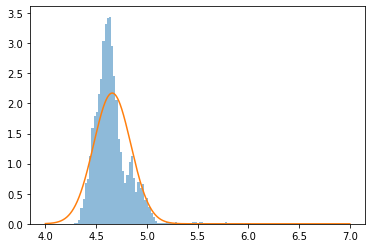

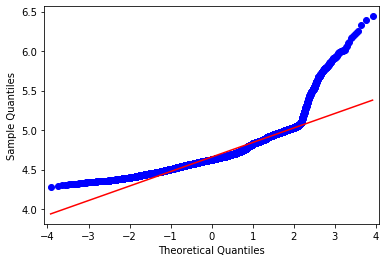

In [7]:
# Build histogram with fitted line assuming normal distribution
myHist = plt.hist(dh_od, 100, density=1, alpha=0.5)

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(dh_od))

m, s = stats.norm.fit(dh_od)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label="Norm");

# Build quantile-quantile plot to visually assess normality
qq = qqplot(np.array(dh_od), line = 's')

# Calculate the statistics to identify if this distribution is normally distributed
stat, p = normaltest(dh_od)
print('Statistic = %.3f, p = %.5f' % (stat, p))

From the histogram and the p-value above, we can tell this data is non-normal. We can also see that it appears bimodal. Let's eliminate the corners that are smaller than 40mm radius (because they're not included in the production-intent design anyway) and see if the resulting dataset is normal.

#### 1.2.3 Full dataset minus sub-40mm corners (i.e. keep the straight lengths and the 40mm corner)

Statistic = 7877.062, p = 0.00000


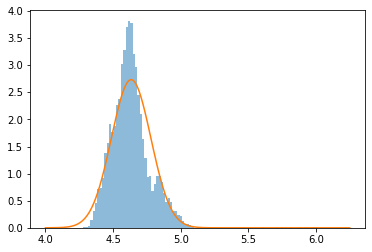

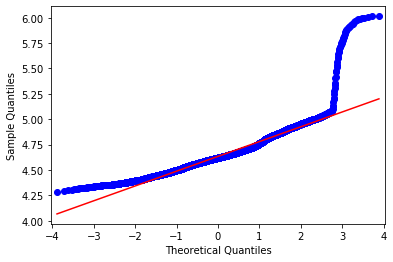

In [9]:
# Build histogram with fitted line assuming normal distribution
myHist1 = plt.hist(dh_o4, 100, density=1, alpha=0.5)

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(dh_o4))

m, s = stats.norm.fit(dh_o4)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label="Norm");

# Build quantile-quantile plot to visually assess normality
qq = qqplot(np.array(dh_o4), line = 's')

# Calculate the statistics to identify if this distribution is normally distributed
stat, p = normaltest(dh_o4)
print('Statistic = %.3f, p = %.5f' % (stat, p))

It's obvious from the plots shown above that the data appears normal but has a larger-than-expected proportion of larger data points. Let's see if we can find out which region is causing the data to be non-normal...

In [10]:
threshold = 5

df_large = df_only40.loc[(df_only40['S1 DHeight'] > threshold) | (df_only40['S2 DHeight'] > threshold) | 
                         (df_only40['S3 DHeight'] > threshold) | (df_only40['S4 DHeight'] > threshold) | 
                         (df_only40['S5 DHeight'] > threshold)]
loc_list = df_large['Location'].tolist()
header_list = ['TOP STRAIGHT (LEFT)', 'FIRST CORNER (30mm RADIUS)', 'LEFT STRAIGHT', 'SECOND CORNER (25mm RADIUS)',
               'BOTTOM STRAIGHT', 'THIRD CORNER (40 mm RADIUS)', 'RIGHT STRAIGHT', 'FOURTH CORNER (35mm RADIUS)', 
               'TOP STRAIGHT (RIGHT)', 'OVERLAP']
for item in header_list:
    print('{:>30}: {}'.format(item, loc_list.count(item)))
#    print(item, ": ", loc_list.count(item))

           TOP STRAIGHT (LEFT): 77
    FIRST CORNER (30mm RADIUS): 0
                 LEFT STRAIGHT: 0
   SECOND CORNER (25mm RADIUS): 0
               BOTTOM STRAIGHT: 0
   THIRD CORNER (40 mm RADIUS): 0
                RIGHT STRAIGHT: 4
   FOURTH CORNER (35mm RADIUS): 0
          TOP STRAIGHT (RIGHT): 59
                       OVERLAP: 0


The cell above reveals that 95% of measurements over 5mm are contained in the top left straight. Measured dry, this section is likely impacted by the overlap in the robot's dispense path, so let's remove it from the dataset and see if our data becomes normal.

Statistics = 555.912, p = 0.00000


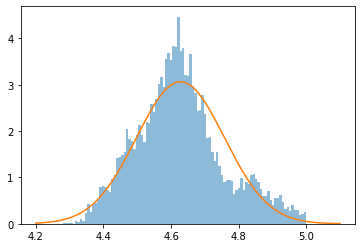

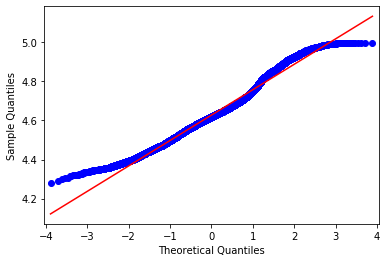

In [11]:
# Create a dataset that ignores the data above 5mm
dh_o4_sub5 = [item for item in dh_o4 if item < threshold]

# Build histogram with fitted line assuming normal distribution
myHist2 = plt.hist(dh_o4_sub5, 100, density=1, alpha=0.5)

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(dh_o4_sub5))

m, s = stats.norm.fit(dh_o4_sub5)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label="Norm");

# Build quantile-quantile plot to visually assess normality
qq = qqplot(np.array(dh_o4_sub5), line = 's')

# Calculate the statistics to identify if this distribution is normally distributed
stat, p = normaltest(dh_o4_sub5)
print('Statistics = %.3f, p = %.5f' % (stat, p))

Our data now *looks* a little more normal but is still is non-normal. Therefore, let's see what distribution best fits our data.

In [12]:
best_fit(dh_o4_sub5)


Distributions listed by Betterment of fit:
............................................
  Distribution    chi_square
8      lognorm    133.233351
4     invgauss    139.274447
6        gamma    141.784201
2  weibull_max    144.361531
3         beta    166.819671
1         norm    263.797893
0  weibull_min    270.577206
5      uniform   9531.805336
7        expon  35795.249287


### 1.3 Exporting the data

At this point, let's export the data so that we can analyze in Minitab.

In [13]:
# 40mm only sub-5mm measurements
df_dh_o4_sub5 = pd.DataFrame(dh_o4_sub5, columns=['Dry Height (mm)'])
df_dh_o4_sub5.to_csv(r'C:\Users\CCOYNE1\Desktop\ML\2020-11-21 only40 sub5.csv', index = False)

In [14]:
# No overlap
df_dh_no = pd.DataFrame(dh_no, columns=['Dry Height (mm)'])
df_dh_no.to_csv(r'C:\Users\CCOYNE1\Desktop\ML\2020-11-21 no overlap.csv', index = False)

In [15]:
# No corners
df_dh_nc = pd.DataFrame(dh_nc, columns=['Dry Height (mm)'])
df_dh_nc.to_csv(r'C:\Users\CCOYNE1\Desktop\ML\2020-11-23 no corners.csv', index = False)

In [16]:
# Only 40mm radius corner
df_dh_o4 = pd.DataFrame(dh_o4, columns=['Dry Height (mm)'])
df_dh_o4.to_csv(r'C:\Users\CCOYNE1\Desktop\ML\2020-11-23 only 40mm corner.csv', index = False)

In [17]:
# All data (original dataframe)
df_dh_od = pd.DataFrame(dh_od, columns=['Dry Height (mm)'])
df_dh_od.to_csv(r'C:\Users\CCOYNE1\Desktop\ML\2020-11-23 all data.csv', index = False)